<a href="https://colab.research.google.com/github/bintangazhari/multiclasstextclassification/blob/main/multicass_text_bintang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a Multiclass text classification (NLP) by Bintang Azhari
This dataset is taken from Kaggle
https://www.kaggle.com/datasets/nelgiriyewithana/shoppersentiments
In this project, I would like to predict the satisfaction level based on the review
The satisfaction level is defined below in the comment

First, Let's try to download the dataset from kaggle

Reference I use:
https://ravi-chan.medium.com/how-to-download-any-data-set-from-kaggle-7e2adc152d7f

In [ ]:
pip install nltk matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import opendatasets
from zipfile import ZipFile
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras.layers import LSTM, Bidirectional

import matplotlib.pyplot as plt

In [ ]:

# Create parent Folder for the project
dir_base = r'C:\Users\Admin\Documents\IDCamp\multiclass-text'
# os.mkdir(dir_base)

# Kaggle API token
token = r'C:\Users\Admin\Downloads\kaggle.json'

# Copy the token into the parent folder
shutil.copy(token, dir_base)

# change directory to parent folder
os.chdir(dir_base)

# download datasets, the output is a folder of dir_base + shoppersentiments
# dataset_url = 'https://www.kaggle.com/datasets/nelgiriyewithana/shoppersentiments'
# opendatasets.download(dataset_url)

# move the dataset into the parent folder
shutil.copy(os.path.join(dir_base,'shoppersentiments\TeePublic_review.csv'), dir_base)


'C:\\Users\\Admin\\Documents\\IDCamp\\multiclass-text\\TeePublic_review.csv'

In [ ]:
# read the file, only take first 50.000 data due to memory error
df = pd.read_csv('TeePublic_review.csv', encoding='latin-1')
df = df.head(10000)

# take the necessary columns and reclassify the review star
# 4-5 is satisfy, 3 is netral, and 1-2 is dissappointed
mydf = df[['review', 'review-label']]
mydf['review-label'].replace([[5,4],3,[2,1]],["satisfy","netral","dissappointed"], inplace=True)
mydf

C:\Users\Admin\AppData\Local\Temp\ipykernel_13216\3546526803.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydf['review-label'].replace([[5,4],3,[2,1]],["satisfy","netral","dissappointed"], inplace=True)


,review,review-label
0,I had an order that was lost in transit. When ...,satisfy
1,I ordered the wrong size tee and had difficult...,satisfy
2,These guys offer the best customer service in ...,satisfy
3,Looked for an obscure phrase on a shirt. Teepu...,satisfy
4,My order arrived in a good timely fashion & th...,satisfy
...,...,...
9995,"Well, I like the design for one, and all your ...",satisfy
9996,Great shirts and the shipping is pretty fast!,satisfy
9997,"Quality look good, size perfect. Iï¿½ï¿½ï¿½ï¿½...",satisfy
9998,The Letters on the Sweater was in Bold Print o...,netral


In [ ]:
# one hot encoding
category = pd.get_dummies(mydf['review-label'])
df_baru = pd.concat([mydf, category], axis=1)
df_baru = df_baru.drop(columns='review-label')
df_baru

# change into numpy array
review = df_baru['review'].values
label = df_baru[['dissappointed', 'netral', 'satisfy' ]].values

Text processing
 cleaning special characters - stemming - lemmatization
Reference:

https://github.com/Snigdho8869/Multiclass-Text-Classification/blob/main/Notebook/Multiclass_Text_Classification.ipynb

https://medium.com/swlh/step-by-step-building-a-multi-class-text-classification-model-with-keras-f78a0209a61a

https://www.dicoding.com/academies/185/tutorials/10149/submission-guidance

In [ ]:
# download the nltk package
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# iterate the process of:
# cleaning special characters - stop words - stemming - lemmatization
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()
new_sentence = []
for text in review:
  text = re.sub('[^a-zA-Z]', ' ', str(text))
  word_tokens = word_tokenize(text)
  filtered_words = [wordnet_lemmatizer.lemmatize(stemmer.stem(w)) for w in word_tokens if not w.lower() in stop_words]
  cleaned_sentence = ' '.join(filtered_words)
  new_sentence.append(cleaned_sentence)

# transform the result back into array
review = np.array(new_sentence)
review


array(['order lost transit call help custom servic repres got new order place right away receiv new order w',
       'order wrong size tee difficulti return websit contact tee public respond almost immedi resolv issu sent new tee shirt high prais excel custom servic',
       'guy offer best custom servic retail product high qualiti fantast select design product option',
       ...,
       'qualiti look good size perfect done mistak command refund correct order quick serv',
       'letter sweater bold print thesoci medium advertis receiv hoodi print much smaller point close person see hoodi say truth reason purchas hoodi first place realli like bold letter said hillman colleg',
       'nan'], dtype='<U1716')

In [ ]:
# split the data into train and validation
review_train, review_test, label_train, label_test = train_test_split(review, label, test_size=0.2)

# tokenizer function
# tokenizer tetap digunakan pada data validation karena hasilnya lebih baik dengan data validation
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(review_train)
tokenizer.fit_on_texts(review_test)


sequence_train = tokenizer.texts_to_sequences(review_train)
sequence_test = tokenizer.texts_to_sequences(review_test)

# pad sequence
padded_train = pad_sequences(sequence_train,padding='post',maxlen=7,truncating='post')
padded_test = pad_sequences(sequence_test,padding='post',maxlen=7,truncating='post')

print(review_train.shape, review_test.shape)
print(label_train.shape, label_test.shape)


(8000,) (2000,)
(8000, 3) (2000, 3)


In [ ]:
# create a model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=256),
    tf.keras.layers.SpatialDropout1D(0.8),
    tf.keras.layers.Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.7)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# create a callback function from inheritance of keras callback
class tf_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.90 and logs.get('accuracy') > 0.90):
            self.model.stop_training = True

callbacks = tf_callback()

In [ ]:
# fit the model
num_epochs = 30
history = model.fit(padded_train, label_train, epochs=num_epochs,
                    validation_data=(padded_test, label_test), verbose=2, callbacks = [callbacks])

Epoch 1/30
250/250 - 33s - loss: 0.4422 - accuracy: 0.8739 - val_loss: 0.3413 - val_accuracy: 0.8850 - 33s/epoch - 130ms/step
Epoch 2/30
250/250 - 27s - loss: 0.3523 - accuracy: 0.8832 - val_loss: 0.3209 - val_accuracy: 0.8990 - 27s/epoch - 108ms/step
Epoch 3/30
250/250 - 27s - loss: 0.3279 - accuracy: 0.8981 - val_loss: 0.3144 - val_accuracy: 0.9020 - 27s/epoch - 109ms/step
Epoch 4/30
250/250 - 27s - loss: 0.3085 - accuracy: 0.9021 - val_loss: 0.3137 - val_accuracy: 0.9010 - 27s/epoch - 109ms/step


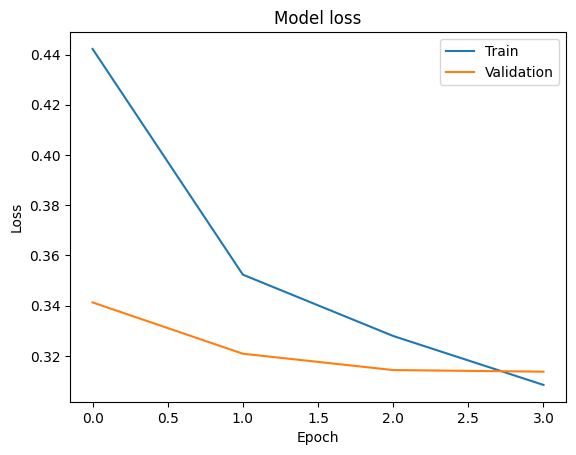

In [ ]:
# plot the result - plot the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

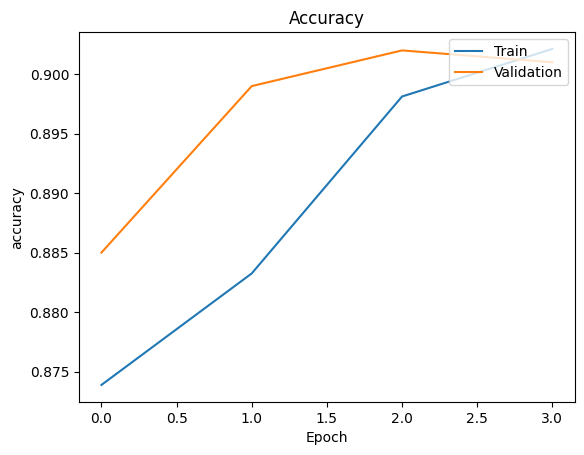

In [ ]:
# plot the model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()